In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
from nltk.tokenize import RegexpTokenizer
from hindi_tokenizer import Tokenizer
import re


from keras.layers import LSTM,Dense,Dropout,Input,Embedding,Bidirectional,Activation,concatenate,dot,TimeDistributed
from keras.models import Model 
from keras import backend as K
from keras import regularizers, constraints, initializers, activations

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data=pd.read_csv("hin.txt",delimiter='\t',header=None,quoting=3)
data.rename(columns={0:'english',1:'hindi'},inplace=True)


# doing something crazy
rem=data.iloc[23,1]
print(rem)
rem=rem[len(rem)-1]


def remove_puntuation_english(s):
    k=re.sub(r'\d+',r'',s)
    k=k.replace(u',','')
    k=k.replace(u'"','')
    k=k.replace(u'(','')
    k=k.replace(u')','')
    k=k.replace(u':','')
    k=k.replace(u'?','')
    k=k.replace(u'!','')
    k=k.replace(u';','')
    k=k.replace(u'.','')
    k=k.replace(u'|','')
    
    return k

def remove_puntuation_hindi(s):
    k=re.sub(r'\d+',r'',s)
    k=k.replace(u',','')
    k=k.replace(u'"','')
    k=k.replace(u'(','')
    k=k.replace(u')','')
    k=k.replace(u':','')
    k=k.replace(u'.','')
    k=k.replace(rem,'')
    k=k.replace(u'!','')
    k=k.replace(u';','')
    k=k.replace(u'?','')
    k=k.replace(u'|','')
    
    return k

data['english']=data['english'].apply(remove_puntuation_english)
data['hindi']=data['hindi'].apply(remove_puntuation_hindi)

data.head()

def func(s):
    return "_".join(s.split())

data['hindi']=data['hindi'].apply(func)
data['english']=data['english'].apply(func)

# i represent '\t' for start of the sentence and '\n' for end of the sentence
# i will add these only to suggestion column as they are target
def add(s):
    return '\t_'+s+'_\n'

data['hindi']=data['hindi'].apply(add)
data.head()

मैं भूल गया।


,english,hindi
0,Wow,\t_वाह_\n
1,Help,\t_बचाओ_\n
2,Jump,\t_उछलो_\n
3,Jump,\t_कूदो_\n
4,Jump,\t_छलांग_\n


In [3]:
def func(s):
    return len(s.split("_"))

data['length']=data['english'].apply(func)
data=data.loc[data['length']<=6]

In [4]:
# finding the maximum query length and maximum suggestion length
def spl(x):
    return len(x.split('_'))
max_length_query=data['english'].apply(spl).max()
max_length_suggestion=data['hindi'].apply(spl).max()
print("The maximum length of input is",max_length_query)
print("The maximum lenght of output is",max_length_suggestion)

The maximum length of input is 6
The maximum lenght of output is 14


In [5]:
input_words=set()
output_words=set()

for i in data['english']:
    for j in i.split('_'):
        input_words.add(j)

for i in data['hindi']:
    for j in i.split('_'):
        output_words.add(j)



input_words=sorted(list(input_words))
output_words=sorted(list(output_words))

# adding <PAD> to the first of the list
input_words=['<PAD>']+input_words
output_words=['<PAD>']+output_words

num_encoder_tokens=len(input_words)
num_decoder_tokens=len(output_words)

# actually mapping between word and it's index

input_token=dict((word,i) for i,word in enumerate(input_words))
output_token=dict((word,i) for i,word in enumerate(output_words))

input_word=dict((i,word) for i,word in enumerate(input_words))
output_word=dict((i,word) for i,word in enumerate(output_words))


print("number of unique input tokens",num_encoder_tokens)
print("number of unique output tokens",num_decoder_tokens)

number of unique input tokens 1718
number of unique output tokens 1874


In [6]:

# setting number of examples as data.shape[0]
num_examples=data.shape[0]



# # making numpy arrays
# encoder_input_data=np.zeros((num_examples,max_length_query,num_encoder_tokens),dtype='float32')
# decoder_input_data=np.zeros((num_examples,max_length_suggestion,num_decoder_tokens),dtype='float32')
# decoder_output_data=np.zeros((num_examples,max_length_suggestion,num_decoder_tokens),dtype='float32')

# # for query
# for i in range(num_examples):
#     # 0 column represents query 
#     sen=frame.iloc[i,0].split('_')
#     for j,word in enumerate(sen):
#         k=input_token[word]
#         encoder_input_data[i,j,k]=1
        
# # for suggestion
# for i in range(num_examples):
#     # 1 column represents suggestion
#     sen=frame.iloc[i,1].split('_')
#     for j,word in enumerate(sen):
#         k=output_token[word]
# #         print(i,j,k,word)
#         decoder_input_data[i,j,k]=1
#         if j>0:
#             decoder_output_data[i,j-1,k]=1
            

# the default data type is 64 bit but i am changing to float32
    
encoder_input_data=np.zeros((num_examples,max_length_query),dtype='float32') 
decoder_input_data=np.zeros((num_examples,max_length_suggestion),dtype='float32') 

decoder_output_data=np.zeros((num_examples,max_length_suggestion,num_decoder_tokens),dtype='float32')
decoder_output_data[:,:,output_token['<PAD>']]=1

# for query
for i in range(num_examples):
    sen=data.iloc[i,0].split('_')
    for j,word in enumerate(sen):
        k=input_token[word]
        encoder_input_data[i,j]=k
        
# for suggestion
for i in range(num_examples):
    # removing \n from the input sequence
    sen=data.iloc[i,1].split('_')
    for j,word in enumerate(sen):
        k=output_token[word]
        decoder_input_data[i,j]=k
        
# for decoder_output_data
for i in range(num_examples):
    # ignoring start of the sentence
    sen=data.iloc[i,1].split('_')
    for j,word in enumerate(sen):
        if j>0:
            k=output_token[word]
            decoder_output_data[i,j-1,k]=1
            decoder_output_data[i,j-1,output_token['<PAD>']]=0


# for our sake we will print the shapes of the array
print("Encoder input data shape",encoder_input_data.shape)
print("Decoder input data shape",decoder_input_data.shape)
print("Decoder output data shape",decoder_output_data.shape)

Encoder input data shape (1708, 6)
Decoder input data shape (1708, 14)
Decoder output data shape (1708, 14, 1874)


In [7]:
embedding_dim=300
hidden_units=300


encoder_input=Input(shape=(max_length_query,))
decoder_input=Input(shape=(max_length_suggestion,))

# embeddding layer for encoder
encoder_embedding=Embedding(num_encoder_tokens,embedding_dim,input_length=max_length_query)
p=encoder_embedding(encoder_input)

# defining the lstm for encoder
encoder_lstm=Bidirectional(LSTM(hidden_units,activation='tanh',return_sequences=True,return_state=True))
encoder_output,state_h,state_c,state_bh,state_bc=encoder_lstm(p)

# you will get output as (batch_size,length_of_sequence,hidden_units)
print(encoder_output)

states=[state_h,state_c,state_bh,state_bc]


# we will define the decoder also 
decoder_embedding=Embedding(num_decoder_tokens,embedding_dim,input_length=max_length_suggestion)
q=decoder_embedding(decoder_input)

decoder_lstm=Bidirectional(LSTM(hidden_units,activation='tanh',return_sequences=True))
decoder_output=decoder_lstm(q,initial_state=states)

print(decoder_output)

# here for scoring, i will implement the dot based scoring 
# this is the important step. The order is important
score=dot([decoder_output,encoder_output],axes=[2,2])
print(score)


# applying the softmax to the score
attention_layer=Activation(activation='softmax')
attention=attention_layer(score)
# shape will be batch_size,
print(attention)

# # try to understand why i did axes=[2,1]
context=dot([attention,encoder_output],axes=[2,1])
print(context)

# now we have to find the attentional hidden state
attentional_hidden_state=concatenate([decoder_output,context])

# apply tanh activation as it is said in the pape
attentional_hidden_state=TimeDistributed(Dense(hidden_units,activation='tanh'))(attentional_hidden_state)

# now apply softmax as suggested in the paper
final_output=TimeDistributed(Dense(num_decoder_tokens,activation='softmax'))(attentional_hidden_state)

model=Model(inputs=[encoder_input,decoder_input],outputs=final_output)
model.summary()

Tensor("bidirectional_1/concat:0", shape=(?, ?, 600), dtype=float32)
Tensor("bidirectional_2/concat:0", shape=(?, ?, 600), dtype=float32)
Tensor("dot_1/MatMul:0", shape=(?, ?, ?), dtype=float32)
Tensor("activation_1/truediv:0", shape=(?, ?, ?), dtype=float32)
Tensor("dot_2/MatMul:0", shape=(?, ?, 600), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 6, 300)       515400      input_1[0][0]         

In [8]:
model.compile(optimizer='adam',loss='categorical_crossentropy')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 6, 300)       515400      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 14, 300)      562200      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectio

In [9]:
batches=10
nepochs=15
p=model.fit([encoder_input_data,decoder_input_data],decoder_output_data,batch_size=batches,epochs=nepochs,validation_split=0.05)

Train on 1622 samples, validate on 86 samples
Epoch 1/15
1622/1622 [==============================] - 15s 9ms/step - loss: 2.8502 - val_loss: 3.3883
Epoch 2/15
1622/1622 [==============================] - 12s 7ms/step - loss: 2.0162 - val_loss: 2.9260
Epoch 3/15
1622/1622 [==============================] - 12s 7ms/step - loss: 1.5590 - val_loss: 2.5626
Epoch 4/15
1622/1622 [==============================] - 12s 7ms/step - loss: 1.1878 - val_loss: 2.4369
Epoch 5/15
1622/1622 [==============================] - 12s 7ms/step - loss: 0.9240 - val_loss: 2.4537
Epoch 6/15
1622/1622 [==============================] - 12s 7ms/step - loss: 0.7075 - val_loss: 2.3355
Epoch 7/15
1622/1622 [==============================] - 12s 7ms/step - loss: 0.5183 - val_loss: 2.3490
Epoch 8/15
1622/1622 [==============================] - 12s 7ms/step - loss: 0.3636 - val_loss: 2.4041
Epoch 9/15
1622/1622 [==============================] - 12s 7ms/step - loss: 0.2417 - val_loss: 2.3730
Epoch 10/15
1622/1622 [====

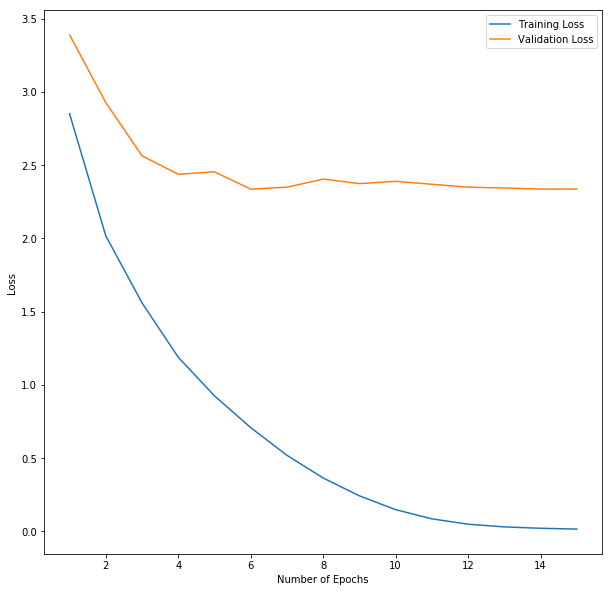

In [10]:
plt.subplots(figsize=(10,10))
plt.plot(range(1,nepochs+1),p.history['loss'],label='Training Loss')
plt.plot(range(1,nepochs+1),p.history['val_loss'],label='Validation Loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()